# Abstractive Text Summarization

[Post](https://towardsdatascience.com/data-scientists-guide-to-summarization-fc0db952e363) on getting started with `text summarization`, their pros and cons and much more.

**There 3 different training models used here**
- `build_seq2seq_model_with_just_lstm` - **Seq2Seq model with just LSTMs**. Both `encoder` and `decoder` have just `LSTM`s.
- `build_seq2seq_model_with_bidirectional_lstm` - **Seq2Seq model with Bidirectional LSTMs**. Both `encoder` and `decoder` have `Bidirectional LSTM`s.
- `build_hybrid_seq2seq_model` - **Seq2Seq model with hybrid architecture**. Here `encoder` has `Bidirectional LSTM`s while `decoder` has just `LSTM`s.

**To see the full learning and results of all the 3 model go to the end of the notebook in the `Running all the 3 different models` section**

The `model (the trained model)`, `encoder_model (for inference)` and `decoder_model (for inference)` for **Seq2Seq with just LSTMs** are only saved.

![](https://media.giphy.com/media/dsKnRuALlWsZG/giphy.gif)

In [1]:
import os
import re
import pickle
import string
import unicodedata
from random import randint

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
from wordcloud import STOPWORDS, WordCloud

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Embedding, TimeDistributed

In [2]:
!pip install -q contractions==0.0.48

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.8/110.8 kB 5.2 MB/s eta 0:00:00


In [3]:
from contractions import contractions_dict

for key, value in list(contractions_dict.items())[:10]:
    print(f'{key} == {value}')

I'm == I am
I'm'a == I am about to
I'm'o == I am going to
I've == I have
I'll == I will
I'll've == I will have
I'd == I would
I'd've == I would have
Whatcha == What are you
amn't == am not


In [4]:
# Using TPU

# detect and init the TPU
tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)

# instantiate a distribution strategy
tpu_strategy = tf.distribute.TPUStrategy(tpu)

## 🪂 Getting the data

In [8]:
filename1 = '/content/news_sum.csv'
filename2 = '/content/news_sum_more.csv'

df1 = pd.read_csv(filename1, encoding='iso-8859-1')
df2 = pd.read_csv(filename2, encoding='iso-8859-1')


In [9]:
df2.shape

(98401, 2)

In [10]:
df1.shape

(4514, 6)

In [11]:
df1.sample(5)

,author,date,headlines,read_more,text,ctext
2392,Tanya Dhingra,"14 Jul 2017,Friday",Kermit the Frog voice actor claims he was fire...,https://www.theguardian.com/culture/2017/jul/1...,"The voice actor of Kermit the Frog, Steve Whit...","Steve Whitmire, the puppeteer who was fired af..."
1785,Parichit Mainra,"02 Jan 2017,Monday",ISIS wants to carry out chemical attacks on UK...,https://www.theguardian.com/world/2017/jan/01/...,UK's Minister of State for Security Ben Wallac...,Islamic State wants to carry out a mass casual...
1758,Vaibhav Gupta,"04 Jan 2017,Wednesday","Kerala suffered ?1,000 crore tourism loss post...",http://indiatoday.intoday.in/story/kerala-suff...,The Kerala government on Tuesday said the stat...,"Minister Thiruvananthapuram, Jan 3 (PTI) Keral..."
3756,Dishant Sharma,"18 Apr 2017,Tuesday",Australia's pace attack could decide Ashes ser...,http://indiatoday.intoday.in/story/brett-lee-a...,Former Australian pacer Brett Lee has said tha...,"Australia's pace attack, emboldened by the ret..."
1189,Rini Sinha,"13 Feb 2017,Monday",Katrina to turn producer and launch sister in ...,http://indiatoday.intoday.in/story/katrina-kai...,"As per reports, actress Katrina Kaif will turn...",When Katrina Kaif's younger sister Isabel made...


In [12]:
df2.sample(5)

,headlines,text
51995,Baaja bajane ki zarurat nahi: Owaisi on Haj su...,After the government withdrew its Haj subsidy ...
74748,"Over 2,000-year-old tombs discovered in Egypt","Three rock-cut tombs, each over 2,000 years ol..."
55372,New Zealand gives volcano same legal rights as...,New Zealand's government has signed an agreeme...
15398,It made no sense: Woman who was in car with ma...,The woman who was in the car with Vivek Tewari...
57982,Syrian teen wins Children's Peace Prize for bu...,"A 16-year-old Syrian refugee, Mohamad Al Jound..."


In [13]:
df1_columns = df1.columns.tolist()
df1_columns.remove('headlines')
df1_columns.remove('text')
df1.drop(df1_columns, axis='columns', inplace=True)

df = pd.concat([df1, df2], axis='rows')
del df1, df2

# Shuffling the df
df = df.sample(frac=1).reset_index(drop=True)

print(f'Dataset size: {len(df)}')
df.sample(5)

Dataset size: 102915


,headlines,text
45730,Amrapali directors' assets may be sold to rais...,The Supreme Court on Tuesday said the only way...
77182,Canadian province ends high heel dress code re...,"The provincial government in British Columbia,..."
55350,Philippine Prez offers Muslim self-rule to cou...,Philippine President Rodrigo Duterte on Monday...
62800,BJP leader compares Rahul to Aurangzeb over te...,Comparing Congress Vice President Rahul Gandhi...
78110,"Man googles how to kill self, jumps off Mumbai...",A 24-year-old businessman allegedly committed ...


The `headlines` column will be treated as `summary` for the text.

## 🏂 Data preparation

In [14]:
def expand_contractions(text, contraction_map=contractions_dict):
    # Using regex for getting all contracted words
    contractions_keys = '|'.join(contraction_map.keys())
    contractions_pattern = re.compile(f'({contractions_keys})', flags=re.DOTALL)

    def expand_match(contraction):
        # Getting entire matched sub-string
        match = contraction.group(0)
        expanded_contraction = contraction_map.get(match)
        if not expand_contractions:
            print(match)
            return match
        return expanded_contraction

    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text


expand_contractions("y'all can't expand contractions i'd think")

'you all can not expand contractions id think'

In [15]:
# Converting to lowercase
df.text = df.text.apply(str.lower)
df.headlines = df.headlines.apply(str.lower)

df.sample(5)

,headlines,text
72813,"bjp asked for 7 days to prove majority, guv ga...",former karnataka cm siddaramaiah has alleged t...
101099,kohli falls 51 runs short of making most runs ...,"virat kohli, who played his last international..."
9781,barkha dutt slams ndtv over use of brand name ...,barkha dutt has slammed her former employer nd...
36611,happy rajini's 2.0 isn't releasing with golmaa...,filmmaker rohit shetty has said he's happy and...
76769,cambodia resumes search for us soldiers killed...,cambodia has agreed to resume a search effort ...


In [16]:
df.headlines = df.headlines.apply(expand_contractions)
df.text = df.text.apply(expand_contractions)
df.sample(5)

,headlines,text
83082,odisha cong mla resigns for failing minor gang...,dalit congress mla krishna chandra sagaria on ...
4711,invite pm modi to walk the talk on corruption:...,karnataka chief minister siddaramaiah on tuesd...
28031,let me just pray: dalit woman on being forced ...,a video showing a group of people forcing a da...
70075,"ayushmann, sanya starrer badhaai hof enters ã¢...","with earnings of ã¢ââ¹100.10 crore, ayushmann..."
97018,the shape of water wins top award at directors...,"guillermo del toro, director of the shape of w..."


In [17]:
# Remove puncuation from word
def rm_punc_from_word(word):
    clean_alphabet_list = [
        alphabet for alphabet in word if alphabet not in string.punctuation
    ]
    return ''.join(clean_alphabet_list)

print(rm_punc_from_word('#cool!'))


# Remove puncuation from text
def rm_punc_from_text(text):
    clean_word_list = [rm_punc_from_word(word) for word in text]
    return ''.join(clean_word_list)

print(rm_punc_from_text("Frankly, my dear, I don't give a damn"))

cool
Frankly my dear I dont give a damn


In [18]:
# Remove numbers from text
def rm_number_from_text(text):
    text = re.sub('[0-9]+', '', text)
    return ' '.join(text.split())  # to rm `extra` white space

print(rm_number_from_text('You are 100times more sexier than me'))
print(rm_number_from_text('If you taught yes then you are 10 times more delusional than me'))

You are times more sexier than me
If you taught yes then you are times more delusional than me


In [19]:
nltk.download('stopwords')
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [20]:
# Remove stopwords from text
def rm_stopwords_from_text(text):
    _stopwords = stopwords.words('english')
    text = text.split()
    word_list = [word for word in text if word not in _stopwords]
    return ' '.join(word_list)

rm_stopwords_from_text("Love means never having to say you're sorry")

'Love means never say sorry'

In [21]:
# Cleaning text
def clean_text(text):
    text = text.lower()
    text = rm_punc_from_text(text)
    text = rm_number_from_text(text)
    text = rm_stopwords_from_text(text)

    # there are hyphen(–) in many titles, so replacing it with empty str
    # this hyphen(–) is different from normal hyphen(-)
    text = re.sub('–', '', text)
    text = ' '.join(text.split())  # removing `extra` white spaces

    # Removing unnecessary characters from text
    text = re.sub("(\\t)", ' ', str(text)).lower()
    text = re.sub("(\\r)", ' ', str(text)).lower()
    text = re.sub("(\\n)", ' ', str(text)).lower()

    # remove accented chars ('Sómě Áccěntěd těxt' => 'Some Accented text')
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode(
        'utf-8', 'ignore'
    )

    text = re.sub("(__+)", ' ', str(text)).lower()
    text = re.sub("(--+)", ' ', str(text)).lower()
    text = re.sub("(~~+)", ' ', str(text)).lower()
    text = re.sub("(\+\++)", ' ', str(text)).lower()
    text = re.sub("(\.\.+)", ' ', str(text)).lower()

    text = re.sub(r"[<>()|&©ø\[\]\'\",;?~*!]", ' ', str(text)).lower()

    text = re.sub("(mailto:)", ' ', str(text)).lower()
    text = re.sub(r"(\\x9\d)", ' ', str(text)).lower()
    text = re.sub("([iI][nN][cC]\d+)", 'INC_NUM', str(text)).lower()
    text = re.sub("([cC][mM]\d+)|([cC][hH][gG]\d+)", 'CM_NUM',
                  str(text)).lower()

    text = re.sub("(\.\s+)", ' ', str(text)).lower()
    text = re.sub("(\-\s+)", ' ', str(text)).lower()
    text = re.sub("(\:\s+)", ' ', str(text)).lower()
    text = re.sub("(\s+.\s+)", ' ', str(text)).lower()

    try:
        url = re.search(r'((https*:\/*)([^\/\s]+))(.[^\s]+)', str(text))
        repl_url = url.group(3)
        text = re.sub(r'((https*:\/*)([^\/\s]+))(.[^\s]+)', repl_url, str(text))
    except Exception as e:
        pass

    text = re.sub("(\s+)", ' ', str(text)).lower()
    text = re.sub("(\s+.\s+)", ' ', str(text)).lower()

    return text

clean_text("Mrs. Robinson, you're trying to seduce me, aren't you?")

'mrs robinson youre trying seduce arent'

In [22]:
df.text = df.text.apply(clean_text)
df.headlines = df.headlines.apply(clean_text)
df.sample(5)

,headlines,text
8551,liverpool chelsea continue winning runs epl,liverpool chelsea continued winning runs engli...
32423,find humane way sundar pichai trumps border po...,referring us president donald trumps border ra...
39065,man behind hoax st held new antihijacking law,jeweller whose hoax hijack note led diversion ...
85685,govt launches clean money portal prevent tax e...,finance minister arun jaitley launched operati...
70230,cops rescue man kidnappers make wear shades night,man made aaa1 crore selling land rescued kidna...


In [23]:
# saving the cleaned data
df.to_csv('/content/Cleaned_data.csv')

In [24]:
# To customize colours of wordcloud texts
def wc_blue_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return "hsl(214, 67%%, %d%%)" % randint(60, 100)


# stopwords for wordcloud
def get_wc_stopwords():
    wc_stopwords = set(STOPWORDS)

    # Adding words to stopwords
    # these words showed up while plotting wordcloud for text
    wc_stopwords.add('s')
    wc_stopwords.add('one')
    wc_stopwords.add('using')
    wc_stopwords.add('example')
    wc_stopwords.add('work')
    wc_stopwords.add('use')
    wc_stopwords.add('make')

    return wc_stopwords


# plot wordcloud
def plot_wordcloud(text, color_func):
    wc_stopwords = get_wc_stopwords()
    wc = WordCloud(stopwords=wc_stopwords, width=1200, height=600, random_state=0).generate(text)

    f, axs = plt.subplots(figsize=(20, 10))
    with sns.axes_style("ticks"):
        sns.despine(offset=10, trim=True)
        plt.imshow(wc.recolor(color_func=color_func, random_state=0), interpolation="bilinear")
        plt.xlabel('WordCloud')

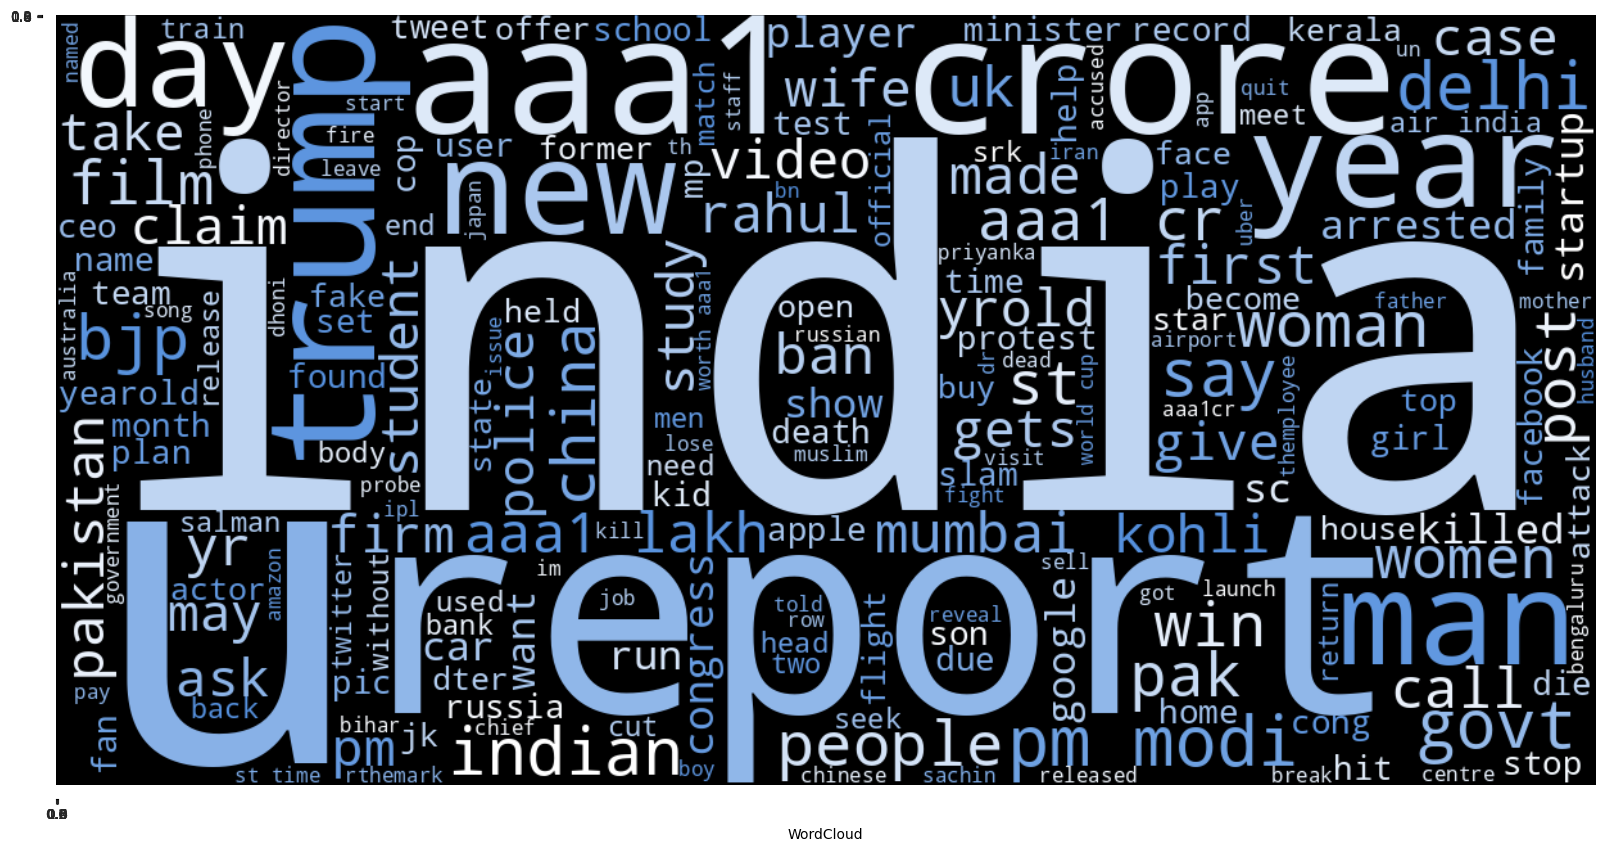

In [25]:
plot_wordcloud(' '.join(df.headlines.values.tolist()), wc_blue_color_func)

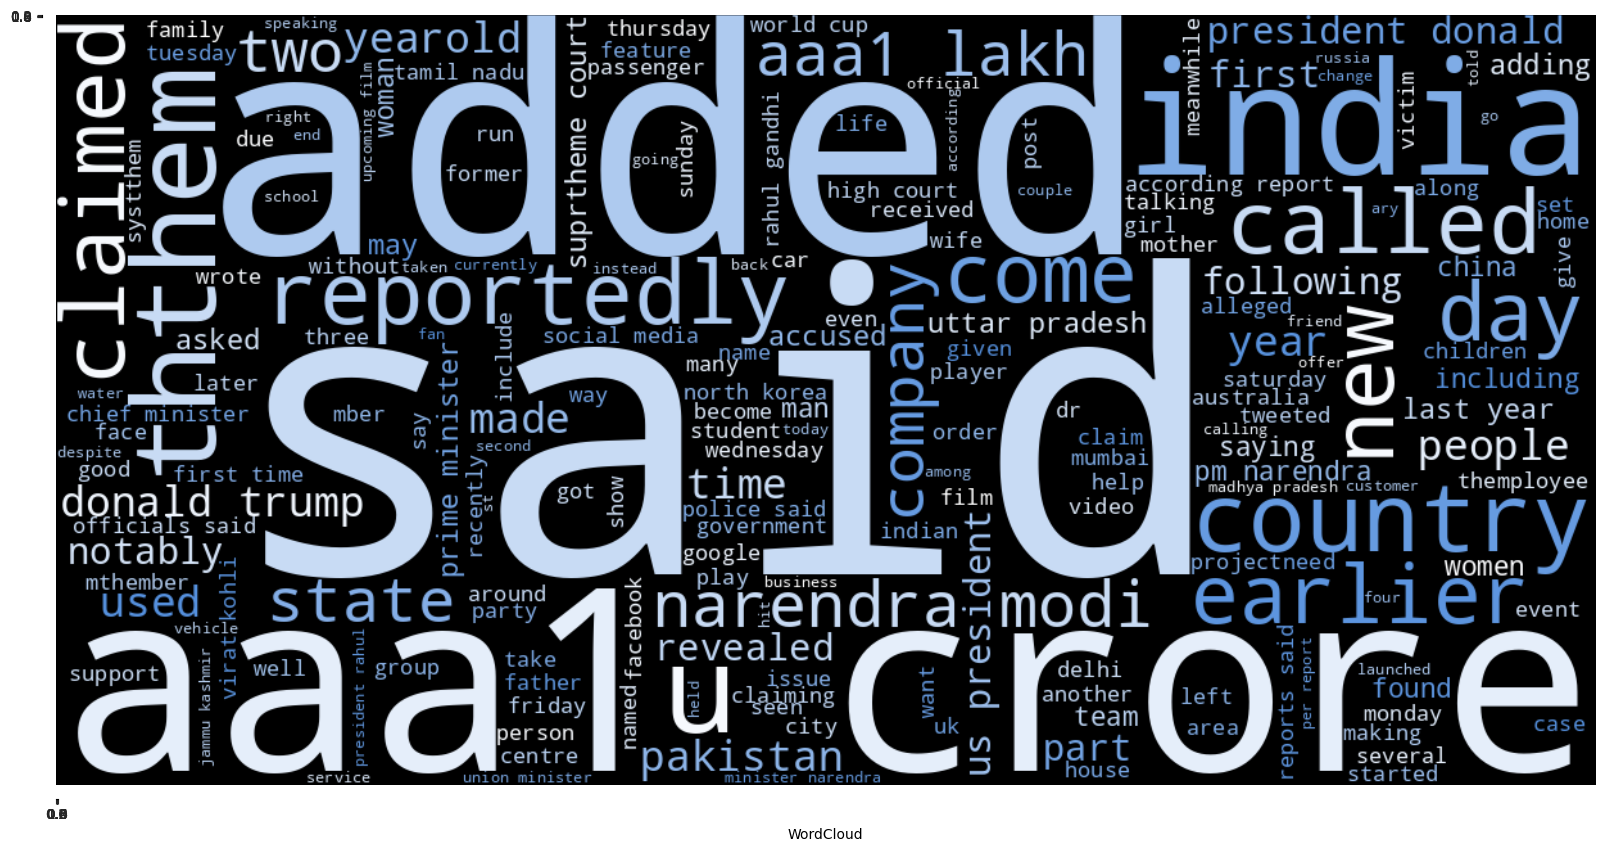

In [26]:
plot_wordcloud(' '.join(df.text.values.tolist()), wc_blue_color_func)

Using a `start` and `end` tokens in `headlines(summary)` to let the learning algorithm know from where the headlines start's and end's.

In [27]:
df.headlines = df.headlines.apply(lambda x: f'_START_ {x} _END_')

Again adding `tokens` ... but different ones.

In [28]:
start_token = 'sostok'
end_token = 'eostok'
df.headlines = df.headlines.apply(lambda x: f'{start_token} {x} {end_token}')

It's important to use `sostok` and `eostok` as start and end tokens respectively as later while using `tensorflow's Tokenizer` will filter the tokens and covert them to lowercase.

**sostok** & **eostok** tokens are for us to know where to start & stop the summary because using `_START_` & `_END_`, tf's tokenizer with convert them to **start** & **end** respectively.

So while decoding the summary sequences of sentences like **'everything is going to end in 2012'** if use `_START_` & `_END_` tokens (which will make the sentence like **'start everything is going to end in 2012 end'** this) whome tf's tokenizer will convert to start and end then we will stop decoding as we hit first **end**, so this is bad and therefore **sostok** & **eostok** these tokens are used.

So we can just use these **sostok** & **eostok** instead of `_START_` & `_END_`, well you can but I tried both ways and while not using these `_START_` & `_END_` I was getting `undesired results` 🤯 😅 i.e. model's `results weren't good`.

In [29]:
df.sample(5)

,headlines,text
28462,sostok _START_ london bridge attackers tried h...,three terrorists ploughed van pedestrians stab...
46783,sostok _START_ times mystery surrounding actor...,actress kajol talking image building changed b...
61323,sostok _START_ china allows president xi jinpi...,china sunday voted amend constitution rthemove...
50198,sostok _START_ steve jobs scammed apples cafet...,former apple senior vice president ios scott f...
50488,sostok _START_ rbi stops printing notes report...,reserve bank india rbi stopped printing curren...


Finding what should be the `maximum length` of text and headlines that will be feed or accepted by the learning algorithm.

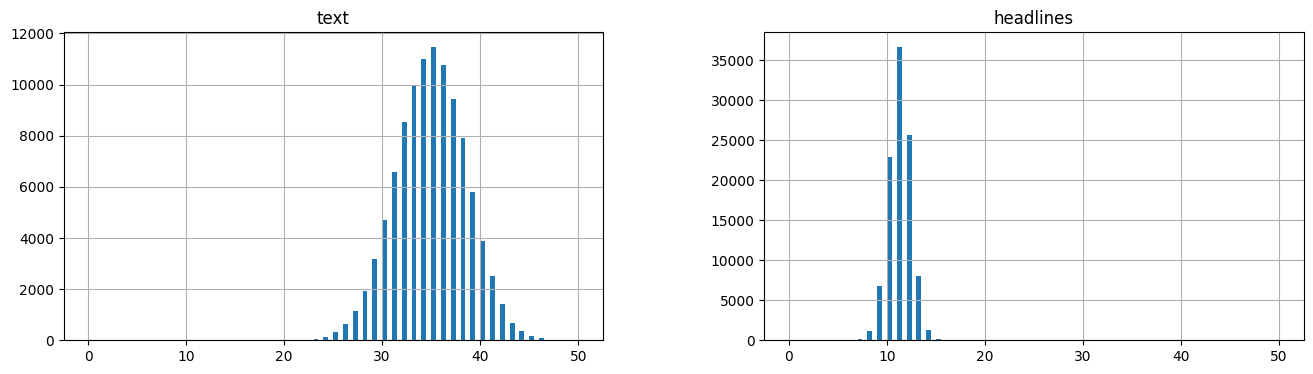

In [30]:
text_count = [len(sentence.split()) for sentence in df.text]
headlines_count = [len(sentence.split()) for sentence in df.headlines]

pd.DataFrame({'text': text_count, 'headlines': headlines_count}).hist(bins=100, figsize=(16, 4), range=[0, 50])
plt.show()

In [31]:
# To check how many rows in a column has length (of the text) <= limit
def get_word_percent(column, limit):
    count = 0
    for sentence in column:
        if len(sentence.split()) <= limit:
            count += 1

    return round(count / len(column), 2)


# Check how many % of headlines have 0-13 words
print(get_word_percent(df.headlines, 13))

# Check how many % of summary have 0-42 words
print(get_word_percent(df.text, 42))

0.99
0.99


If the length of headlines or the text is kept large the deep learning model will face issues with performance and also training will slower.

One solution for creating summary for long sentences can be break a paragraph into sentences and then create a summary for them, this way the summary will make sence instead of giving random piece of text and creating summary for it.

In [32]:
max_text_len = 42
max_summary_len = 13

In [33]:
# select the summary and text between their defined max lens respectively
def trim_text_and_summary(df, max_text_len, max_summary_len):
    cleaned_text = np.array(df['text'])
    cleaned_summary = np.array(df['headlines'])

    short_text = []
    short_summary = []

    for i in range(len(cleaned_text)):
        if len(cleaned_text[i].split()) <= max_text_len and len(
            cleaned_summary[i].split()
        ) <= max_summary_len:
            short_text.append(cleaned_text[i])
            short_summary.append(cleaned_summary[i])

    df = pd.DataFrame({'text': short_text, 'summary': short_summary})
    return df


df = trim_text_and_summary(df, max_text_len, max_summary_len)
print(f'Dataset size: {len(df)}')
df.sample(5)

Dataset size: 100258


,text,summary
79487,samsung researchers developed technology claim...,sostok _START_ samsung develops tech fully cha...
40943,actor anupam kher talking actor tom alter pass...,sostok _START_ tom american indian many indian...
70363,team danish swedish researchers studied billio...,sostok _START_ bnyrold fossils made oxygen bub...
89603,researchers reported discovery new ant species...,sostok _START_ ant species explodes defend col...
46669,new song chogada aayush sharma warina hussain ...,sostok _START_ chogada song aayush warinas lov...


In [34]:
# rare word analysis
def get_rare_word_percent(tokenizer, threshold):
    # threshold: if the word's occurrence is less than this then it's rare word

    count = 0
    total_count = 0
    frequency = 0
    total_frequency = 0

    for key, value in tokenizer.word_counts.items():
        total_count += 1
        total_frequency += value
        if value < threshold:
            count += 1
            frequency += value

    return {
        'percent': round((count / total_count) * 100, 2),
        'total_coverage': round(frequency / total_frequency * 100, 2),
        'count': count,
        'total_count': total_count
    }

![](https://media.giphy.com/media/3o72EUwmrRFtyT1Vhm/giphy.gif)

In [35]:
# Splitting the training and validation sets
x_train, x_val, y_train, y_val = train_test_split(
    np.array(df['text']),
    np.array(df['summary']),
    test_size=0.1,
    random_state=1,
    shuffle=True
)

**Tokenizing text 👉 x**

In [36]:
x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(list(x_train))

x_tokens_data = get_rare_word_percent(x_tokenizer, 4)
print(x_tokens_data)

{'percent': 65.25, 'total_coverage': 2.95, 'count': 65031, 'total_count': 99658}


🔥 to `increase computation speed` use this

```python
x_tokenizer = Tokenizer(num_words=x_tokens_data['total_count'] - x_tokens_data['count'])
```

In [37]:
# else use this
x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(list(x_train))

In [38]:
# save tokenizer
with open('x_tokenizer', 'wb') as f:
    pickle.dump(x_tokenizer, f, protocol=pickle.HIGHEST_PROTOCOL)

In [39]:
# one-hot-encoding
x_train_sequence = x_tokenizer.texts_to_sequences(x_train)
x_val_sequence = x_tokenizer.texts_to_sequences(x_val)

# padding upto max_text_len
x_train_padded = pad_sequences(x_train_sequence, maxlen=max_text_len, padding='post')
x_val_padded = pad_sequences(x_val_sequence, maxlen=max_text_len, padding='post')

# if you're not using num_words parameter in Tokenizer then use this
x_vocab_size = len(x_tokenizer.word_index) + 1

# else use this
# x_vocab_size = x_tokenizer.num_words + 1

print(x_vocab_size)

99659


**Tokenizing headlines(summary) 👉 y**

In [40]:
y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(y_train))

y_tokens_data = get_rare_word_percent(y_tokenizer, 6)
print(y_tokens_data)

{'percent': 69.13, 'total_coverage': 4.79, 'count': 25855, 'total_count': 37400}


🔥 to `increase computation speed` use this

```python
y_tokenizer = Tokenizer(num_words=y_tokens_data['total_count'] - y_tokens_data['count'])
```

In [41]:
# else use this
y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(y_train))

In [42]:
# save tokenizer
with open('y_tokenizer', 'wb') as f:
    pickle.dump(y_tokenizer, f, protocol=pickle.HIGHEST_PROTOCOL)

In [43]:
# one-hot-encoding
y_train_sequence = y_tokenizer.texts_to_sequences(y_train)
y_val_sequence = y_tokenizer.texts_to_sequences(y_val)

# padding upto max_summary_len
y_train_padded = pad_sequences(y_train_sequence, maxlen=max_summary_len, padding='post')
y_val_padded = pad_sequences(y_val_sequence, maxlen=max_summary_len, padding='post')

# if you're not using num_words parameter in Tokenizer then use this
y_vocab_size = len(y_tokenizer.word_index) + 1

# else use this
# y_vocab_size = y_tokenizer.num_words + 1

print(y_vocab_size)

37401


In [44]:
# removing summary which only has sostok & eostok
def remove_indexes(summary_array):
    remove_indexes = []
    for i in range(len(summary_array)):
        count = 0
        for j in summary_array[i]:
            if j != 0:
                count += 1
        if count == 2:
            remove_indexes.append(i)
    return remove_indexes


remove_train_indexes = remove_indexes(y_train_padded)
remove_val_indexes = remove_indexes(y_val_padded)

y_train_padded = np.delete(y_train_padded, remove_train_indexes, axis=0)
x_train_padded = np.delete(x_train_padded, remove_train_indexes, axis=0)

y_val_padded = np.delete(y_val_padded, remove_val_indexes, axis=0)
x_val_padded = np.delete(x_val_padded, remove_val_indexes, axis=0)

## 🤼‍♂️ Modelling

![](https://media.giphy.com/media/YTJXDIivNMPuNSMgc0/giphy.gif)

In [45]:
latent_dim = 240
embedding_dim = 300
num_epochs = 50

In [47]:
def get_embedding_matrix(tokenizer, embedding_dim, vocab_size=None):
    word_index = tokenizer.word_index
    voc = list(word_index.keys())

    path_to_glove_file = '/glove.6B.300d.txt'

    embeddings_index = {}
    with open(path_to_glove_file) as f:
        for line in f:
            word, coefs = line.split(maxsplit=1)
            coefs = np.fromstring(coefs, "f", sep=" ")
            embeddings_index[word] = coefs

    print("Found %s word vectors." % len(embeddings_index))

    num_tokens = len(voc) + 2 if not vocab_size else vocab_size
    hits = 0
    misses = 0

    # Prepare embedding matrix
    embedding_matrix = np.zeros((num_tokens, embedding_dim))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros.
            # This includes the representation for "padding" and "OOV"
            embedding_matrix[i] = embedding_vector
            hits += 1
        else:
            misses += 1
    print("Converted %d words (%d misses)" % (hits, misses))

    return embedding_matrix


x_embedding_matrix = get_embedding_matrix(x_tokenizer, embedding_dim, x_vocab_size)
y_embedding_matrix = get_embedding_matrix(y_tokenizer, embedding_dim, y_vocab_size)

Found 6054 word vectors.


ValueError: ignored

In [48]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
print(x_embedding_matrix.shape)
print(y_embedding_matrix.shape)

(99810, 300)
(37469, 300)


Using `pre-trained` embeddings and keeping the `Embedding` layer `non-trainable` we get increase in computation speed as don't need to compute the embedding matrix.

**Here there 3 different training models**
- `build_seq2seq_model_with_just_lstm` - **Seq2Seq model with just LSTMs**. Both `encoder` and `decoder` have just `LSTM`s.
- `build_seq2seq_model_with_bidirectional_lstm` - **Seq2Seq model with Bidirectional LSTMs**. Both `encoder` and `decoder` have `Bidirectional LSTM`s.
- `build_hybrid_seq2seq_model` - **Seq2Seq model with hybrid architecture**. Here `encoder` has `Bidirectional LSTM`s while `decoder` has just `LSTM`s.

**Inference methods for the 3 different learning models - just add `_inference` as `prefix`**
- `build_seq2seq_model_with_just_lstm_inference`
- `build_seq2seq_model_with_bidirectional_lstm_inference`
- `build_hybrid_seq2seq_model_inference`

**Decoding sequence for the 3 different learning models - just add `decode_sequence_` as `suffix`**
- `decode_sequence_build_seq2seq_model_with_just_lstm`
- `decode_sequence_build_seq2seq_model_with_bidirectional_lstm`
- `decode_sequence_build_hybrid_seq2seq_model`

**Seq2Seq model with just LSTMs**. Both `encoder` and `decoder` have just `LSTM`s.

In [ ]:
def build_seq2seq_model_with_just_lstm(
    embedding_dim, latent_dim, max_text_len,
    x_vocab_size, y_vocab_size,
    x_embedding_matrix, y_embedding_matrix
):
    # instantiating the model in the strategy scope creates the model on the TPU
    with tpu_strategy.scope():

        # =====================
        # 🔥 Encoder
        # =====================
        encoder_input = Input(shape=(max_text_len, ))

        # encoder embedding layer
        encoder_embedding = Embedding(
            x_vocab_size,
            embedding_dim,
            embeddings_initializer=tf.keras.initializers.Constant(x_embedding_matrix),
            trainable=False
        )(encoder_input)

        # encoder lstm 1
        encoder_lstm1 = LSTM(
            latent_dim,
            return_sequences=True,
            return_state=True,
            dropout=0.4,
            recurrent_dropout=0.4
        )
        encoder_output1, state_h1, state_c1 = encoder_lstm1(encoder_embedding)

        # encoder lstm 2
        encoder_lstm2 = LSTM(
            latent_dim,
            return_sequences=True,
            return_state=True,
            dropout=0.4,
            recurrent_dropout=0.4
        )
        encoder_output, *encoder_final_states = encoder_lstm2(encoder_output1)

        # =====================
        # 🌈 Decoder
        # =====================

        # Set up the decoder, using `encoder_states` as initial state.

        decoder_input = Input(shape=(None, ))

        # decoder embedding layer
        decoder_embedding_layer = Embedding(
            y_vocab_size,
            embedding_dim,
            embeddings_initializer=tf.keras.initializers.Constant(y_embedding_matrix),
            trainable=True
        )
        decoder_embedding = decoder_embedding_layer(decoder_input)

        # decoder lstm 1
        decoder_lstm = LSTM(
            latent_dim,
            return_sequences=True,
            return_state=True,
            dropout=0.4,
            recurrent_dropout=0.4
        )
        decoder_output, *decoder_final_states = decoder_lstm(
            decoder_embedding, initial_state=encoder_final_states
        )

        # dense layer
        decoder_dense = TimeDistributed(
            Dense(y_vocab_size, activation='softmax')
        )
        decoder_output = decoder_dense(decoder_output)

        # =====================
        # ⚡️ Model
        # =====================
        model = Model([encoder_input, decoder_input], decoder_output)
        model.summary()

        optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)
        model.compile(
            optimizer=optimizer,
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )

        return {
            'model': model,
            'inputs': {
                'encoder': encoder_input,
                'decoder': decoder_input
            },
            'outputs': {
                'encoder': encoder_output,
                'decoder': decoder_output
            },
            'states': {
                'encoder': encoder_final_states,
                'decoder': decoder_final_states
            },
            'layers': {
                'decoder': {
                    'embedding': decoder_embedding_layer,
                    'last_decoder_lstm': decoder_lstm,
                    'dense': decoder_dense
                }
            }
        }

**Seq2Seq model with Bidirectional LSTMs**. Both `encoder` and `decoder` have `Bidirectional LSTM`s.

In [ ]:
def build_seq2seq_model_with_bidirectional_lstm(
    embedding_dim, latent_dim, max_text_len,
    x_vocab_size, y_vocab_size,
    x_embedding_matrix, y_embedding_matrix
):
    # instantiating the model in the strategy scope creates the model on the TPU
    with tpu_strategy.scope():

        # =====================
        # 🔥 Encoder
        # =====================
        encoder_input = Input(shape=(max_text_len, ))

        # encoder embedding layer
        encoder_embedding = Embedding(
            x_vocab_size,
            embedding_dim,
            embeddings_initializer=tf.keras.initializers.Constant(x_embedding_matrix),
            trainable=False,
            name='encoder_embedding'
        )(encoder_input)

        # encoder lstm1
        encoder_bi_lstm1 = Bidirectional(
            LSTM(
                latent_dim,
                return_sequences=True,
                return_state=True,
                dropout=0.4,
                recurrent_dropout=0.4,
                name='encoder_lstm_1'
            ),
            name='encoder_bidirectional_lstm_1'
        )
        encoder_output1, forward_h1, forward_c1, backward_h1, backward_c1 = encoder_bi_lstm1(
            encoder_embedding
        )
        encoder_bi_lstm1_output = [
            encoder_output1, forward_h1, forward_c1, backward_h1, backward_c1
        ]

        # encoder lstm 2
        encoder_bi_lstm2 = Bidirectional(
            LSTM(
                latent_dim,
                return_sequences=True,
                return_state=True,
                dropout=0.4,
                recurrent_dropout=0.4,
                name='encoder_lstm_2'
            ),
            name='encoder_bidirectional_lstm_2'
        )
        encoder_output2, forward_h2, forward_c2, backward_h2, backward_c2 = encoder_bi_lstm2(
            encoder_output1
        )
        encoder_bi_lstm2_output = [
            encoder_output2, forward_h2, forward_c2, backward_h2, backward_c2
        ]

        # encoder lstm 3
        encoder_bi_lstm = Bidirectional(
            LSTM(
                latent_dim,
                return_sequences=True,
                return_state=True,
                dropout=0.4,
                recurrent_dropout=0.4,
                name='encoder_lstm_3'
            ),
            name='encoder_bidirectional_lstm_3'
        )
        encoder_output, *encoder_final_states = encoder_bi_lstm(encoder_output2)

        # =====================
        # 🌈 Decoder
        # =====================

        # Set up the decoder, using `encoder_states` as initial state.

        decoder_input = Input(shape=(None, ))

        # decoder embedding layer
        decoder_embedding_layer = Embedding(
            y_vocab_size,
            embedding_dim,
            embeddings_initializer=tf.keras.initializers.Constant(y_embedding_matrix),
            trainable=False,
            name='decoder_embedding'
        )
        decoder_embedding = decoder_embedding_layer(decoder_input)

        decoder_bi_lstm = Bidirectional(
            LSTM(
                latent_dim,
                return_sequences=True,
                return_state=True,
                dropout=0.4,
                recurrent_dropout=0.2,
                name='decoder_lstm_1'
            ),
            name='decoder_bidirectional_lstm_1'
        )
        decoder_output, *decoder_final_states = decoder_bi_lstm(
            decoder_embedding, initial_state=encoder_final_states
            # decoder_embedding, initial_state=encoder_final_states[:2]
        )  # taking only the forward states

        # dense layer
        decoder_dense = TimeDistributed(
            Dense(y_vocab_size, activation='softmax')
        )
        decoder_output = decoder_dense(decoder_output)

        # =====================
        # ⚡️ Model
        # =====================
        model = Model([encoder_input, decoder_input], decoder_output, name='seq2seq_model_with_bidirectional_lstm')
        model.summary()

        optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)
        model.compile(
            optimizer=optimizer,
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )

        return {
            'model': model,
            'inputs': {
                'encoder': encoder_input,
                'decoder': decoder_input
            },
            'outputs': {
                'encoder': encoder_output,
                'decoder': decoder_output
            },
            'states': {
                'encoder': encoder_final_states,
                'decoder': decoder_final_states
            },
            'layers': {
                'decoder': {
                    'embedding': decoder_embedding_layer,
                    'last_decoder_lstm': decoder_bi_lstm,
                    'dense': decoder_dense
                }
            }
        }

**Seq2Seq model with hybrid architecture**. Here `encoder` has `Bidirectional LSTM`s while `decoder` has just `LSTM`s.

In [ ]:
def build_hybrid_seq2seq_model(
    embedding_dim, latent_dim, max_text_len,
    x_vocab_size, y_vocab_size,
    x_embedding_matrix, y_embedding_matrix
):
    # instantiating the model in the strategy scope creates the model on the TPU
    with tpu_strategy.scope():

        # =====================
        # 🔥 Encoder
        # =====================
        encoder_input = Input(shape=(max_text_len, ))

        # encoder embedding layer
        encoder_embedding = Embedding(
            x_vocab_size,
            embedding_dim,
            embeddings_initializer=tf.keras.initializers.Constant(x_embedding_matrix),
            trainable=False,
            name='encoder_embedding'
        )(encoder_input)

        # encoder lstm1
        encoder_bi_lstm1 = Bidirectional(
            LSTM(
                latent_dim,
                return_sequences=True,
                return_state=True,
                dropout=0.4,
                recurrent_dropout=0.4,
                name='encoder_lstm_1'
            ),
            name='encoder_bidirectional_lstm_1'
        )
        encoder_output1, forward_h1, forward_c1, backward_h1, backward_c1 = encoder_bi_lstm1(
            encoder_embedding
        )
        encoder_bi_lstm1_output = [
            encoder_output1, forward_h1, forward_c1, backward_h1, backward_c1
        ]

        # encoder lstm 2
        encoder_bi_lstm2 = Bidirectional(
            LSTM(
                latent_dim,
                return_sequences=True,
                return_state=True,
                dropout=0.4,
                recurrent_dropout=0.4,
                name='encoder_lstm_2'
            ),
            name='encoder_bidirectional_lstm_2'
        )
        encoder_output2, forward_h2, forward_c2, backward_h2, backward_c2 = encoder_bi_lstm2(
            encoder_output1
        )
        encoder_bi_lstm2_output = [
            encoder_output2, forward_h2, forward_c2, backward_h2, backward_c2
        ]

        # encoder lstm 3
        encoder_bi_lstm = Bidirectional(
            LSTM(
                latent_dim,
                return_sequences=True,
                return_state=True,
                dropout=0.4,
                recurrent_dropout=0.4,
                name='encoder_lstm_3'
            ),
            name='encoder_bidirectional_lstm_3'
        )
        encoder_output, *encoder_final_states = encoder_bi_lstm(encoder_output2)

        # =====================
        # 🌈 Decoder
        # =====================

        # Set up the decoder, using `encoder_states` as initial state.

        decoder_input = Input(shape=(None, ))

        # decoder embedding layer
        decoder_embedding_layer = Embedding(
            y_vocab_size,
            embedding_dim,
            embeddings_initializer=tf.keras.initializers.Constant(y_embedding_matrix),
            trainable=False,
            name='decoder_embedding'
        )
        decoder_embedding = decoder_embedding_layer(decoder_input)

        decoder_lstm = LSTM(
            latent_dim,
            return_sequences=True,
            return_state=True,
            dropout=0.4,
            recurrent_dropout=0.2,
            name='decoder_lstm_1'
        )
        decoder_output, *decoder_final_states = decoder_lstm(
            decoder_embedding, initial_state=encoder_final_states[:2]
        )  # taking only the forward states

        # dense layer
        decoder_dense = TimeDistributed(
            Dense(y_vocab_size, activation='softmax')
        )
        decoder_output = decoder_dense(decoder_output)

        # =====================
        # ⚡️ Model
        # =====================
        model = Model([encoder_input, decoder_input], decoder_output, name='seq2seq_model_with_bidirectional_lstm')
        model.summary()

        optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)
        model.compile(
            optimizer=optimizer,
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )

        return {
            'model': model,
            'inputs': {
                'encoder': encoder_input,
                'decoder': decoder_input
            },
            'outputs': {
                'encoder': encoder_output,
                'decoder': decoder_output
            },
            'states': {
                'encoder': encoder_final_states,
                'decoder': decoder_final_states
            },
            'layers': {
                'decoder': {
                    'embedding': decoder_embedding_layer,
                    'last_decoder_lstm': decoder_lstm,
                    'dense': decoder_dense
                }
            }
        }

In [ ]:
seq2seq = build_seq2seq_model_with_just_lstm(
    embedding_dim, latent_dim, max_text_len,
    x_vocab_size, y_vocab_size,
    x_embedding_matrix, y_embedding_matrix
)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 42)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 42, 300)      29943000    ['input_1[0][0]']                
                                                                                                  
 input_2 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 lstm (LSTM)                    [(None, 42, 240),    519360      ['embedding[0][0]']              
                                 (None, 240),                                                 

If you want to change `model` then just change the `function name` above.

In [ ]:
model = seq2seq['model']

encoder_input = seq2seq['inputs']['encoder']
decoder_input = seq2seq['inputs']['decoder']

encoder_output = seq2seq['outputs']['encoder']
decoder_output = seq2seq['outputs']['decoder']

encoder_final_states = seq2seq['states']['encoder']
decoder_final_states = seq2seq['states']['decoder']

decoder_embedding_layer = seq2seq['layers']['decoder']['embedding']
last_decoder_lstm = seq2seq['layers']['decoder']['last_decoder_lstm']
decoder_dense = seq2seq['layers']['decoder']['dense']

In [ ]:
model.layers[-2].input

[<KerasTensor: shape=(None, None, 300) dtype=float32 (created by layer 'embedding_1')>,
 <KerasTensor: shape=(None, 240) dtype=float32 (created by layer 'lstm_1')>,
 <KerasTensor: shape=(None, 240) dtype=float32 (created by layer 'lstm_1')>]

In [ ]:
callbacks = [
    EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=0.000001, verbose=1),
]

Use a `tuple` instead of `list` in `validation_parameter` in `model.fit()`, to know the reason reading this [post](https://stackoverflow.com/questions/61586981/valueerror-layer-sequential-20-expects-1-inputs-but-it-received-2-input-tensor).

In [ ]:
history = model.fit(
    [x_train_padded, y_train_padded[:, :-1]],
    y_train_padded.reshape(y_train_padded.shape[0], y_train_padded.shape[1], 1)[:, 1:],
    epochs=num_epochs,
    batch_size=128 * tpu_strategy.num_replicas_in_sync,
    callbacks=callbacks,
    validation_data=(
        [x_val_padded, y_val_padded[:, :-1]],
        y_val_padded.reshape(y_val_padded.shape[0], y_val_padded.shape[1], 1)[:, 1:]
    )
)

Epoch 1/50
89/89 [==============================] - 59s 374ms/step - loss: 6.6295 - accuracy: 0.2566 - val_loss: 5.5621 - val_accuracy: 0.3246 - lr: 0.0010
Epoch 2/50
89/89 [==============================] - 10s 116ms/step - loss: 5.5178 - accuracy: 0.3318 - val_loss: 5.2144 - val_accuracy: 0.3505 - lr: 0.0010
Epoch 3/50
89/89 [==============================] - 10s 115ms/step - loss: 5.2867 - accuracy: 0.4115 - val_loss: 5.0734 - val_accuracy: 0.4326 - lr: 0.0010
Epoch 4/50
89/89 [==============================] - 10s 114ms/step - loss: 5.2014 - accuracy: 0.4189 - val_loss: 5.0272 - val_accuracy: 0.4329 - lr: 0.0010
Epoch 5/50
89/89 [==============================] - 10s 114ms/step - loss: 5.1753 - accuracy: 0.4193 - val_loss: 5.0009 - val_accuracy: 0.4333 - lr: 0.0010
Epoch 6/50
89/89 [==============================] - 10s 114ms/step - loss: 5.1595 - accuracy: 0.4195 - val_loss: 4.9988 - val_accuracy: 0.4334 - lr: 0.0010
Epoch 7/50
89/89 [==============================] - 10s 113ms/st

**Plotting model's performance**

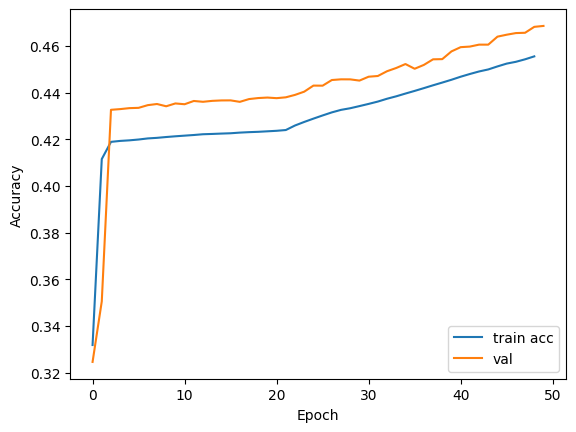

In [ ]:
# Accuracy
plt.plot(history.history['accuracy'][1:], label='train acc')
plt.plot(history.history['val_accuracy'], label='val')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

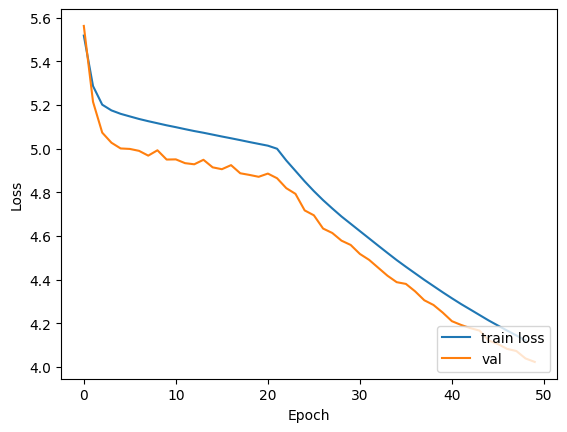

In [ ]:
# Loss
plt.plot(history.history['loss'][1:], label='train loss')
plt.plot(history.history['val_loss'], label='val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')

## 🤸‍♂️ Inference

![](https://media.giphy.com/media/5FJcVeYFVysda/giphy.gif)

In [ ]:
# Next, let’s build the dictionary to convert the index to word for target and source vocabulary:
reverse_target_word_index = y_tokenizer.index_word
reverse_source_word_index = x_tokenizer.index_word
target_word_index = y_tokenizer.word_index

In [ ]:
def build_seq2seq_model_with_just_lstm_inference(
    max_text_len, latent_dim, encoder_input, encoder_output,
    encoder_final_states, decoder_input, decoder_output,
    decoder_embedding_layer, decoder_dense, last_decoder_lstm
):
    # Encode the input sequence to get the feature vector
    encoder_model = Model(
        inputs=encoder_input, outputs=[encoder_output] + encoder_final_states
    )

    # Decoder setup
    # Below tensors will hold the states of the previous time step
    decoder_state_input_h = Input(shape=(latent_dim, ))
    decoder_state_input_c = Input(shape=(latent_dim, ))
    decoder_hidden_state_input = Input(shape=(max_text_len, latent_dim))

    # Get the embeddings of the decoder sequence
    decoder_embedding = decoder_embedding_layer(decoder_input)

    # To predict the next word in the sequence, set the initial
    # states to the states from the previous time step
    decoder_output, *decoder_states = last_decoder_lstm(
        decoder_embedding,
        initial_state=[decoder_state_input_h, decoder_state_input_c]
    )

    # A dense softmax layer to generate prob dist. over the target vocabulary
    decoder_output = decoder_dense(decoder_output)

    # Final decoder model
    decoder_model = Model(
        [decoder_input] + [decoder_hidden_state_input, decoder_state_input_h, decoder_state_input_c],
        [decoder_output] + decoder_states
    )

    return (encoder_model, decoder_model)

Useful `stackoverflow` [post](https://stackoverflow.com/questions/60697843/tensorflow-keras-bidirectional-lstm-for-text-summarization) to understand `inference` process when using `bidirectional lstms` in `encoder` and `decoder` in the training model.

In [ ]:
def build_seq2seq_model_with_bidirectional_lstm_inference(
    max_text_len, latent_dim, encoder_input, encoder_output,
    encoder_final_states, decoder_input, decoder_output,
    decoder_embedding_layer, decoder_dense, last_decoder_bi_lstm
):

    # Encode the input sequence to get the feature vector
    encoder_model = Model(
        inputs=encoder_input, outputs=[encoder_output] + encoder_final_states
    )

    # Decoder setup
    # Below tensors will hold the states of the previous time step
    decoder_state_forward_input_h = Input(shape=(latent_dim, ))
    decoder_state_forward_input_c = Input(shape=(latent_dim, ))
    decoder_state_backward_input_h = Input(shape=(latent_dim, ))
    decoder_state_backward_input_c = Input(shape=(latent_dim, ))

    # Create the hidden input layer with twice the latent dimension,
    # since we are using bi - directional LSTM's we will get
    # two hidden states and two cell states
    decoder_hidden_state_input = Input(shape=(max_text_len, latent_dim * 2))

    decoder_initial_state = [
        decoder_state_forward_input_h, decoder_state_forward_input_c,
        decoder_state_backward_input_h, decoder_state_backward_input_c
    ]

    # Get the embeddings of the decoder sequence
    decoder_embedding = decoder_embedding_layer(decoder_input)

    # To predict the next word in the sequence, set the initial
    # states to the states from the previous time step
    decoder_output, *decoder_states = last_decoder_bi_lstm(
        decoder_embedding, initial_state=decoder_initial_state
    )

    # A dense softmax layer to generate prob dist. over the target vocabulary
    decoder_output = decoder_dense(decoder_output)

    # Final decoder model
    decoder_model = Model(
        [decoder_input] + [decoder_hidden_state_input] + decoder_initial_state,
        [decoder_output] + decoder_states
    )

    return (encoder_model, decoder_model)

In [ ]:
def build_hybrid_seq2seq_model_inference(
    max_text_len, latent_dim, encoder_input, encoder_output,
    encoder_final_states, decoder_input, decoder_output,
    decoder_embedding_layer, decoder_dense, last_decoder_bi_lstm
):

    # Encode the input sequence to get the feature vector
    encoder_model = Model(
        inputs=encoder_input, outputs=[encoder_output] + encoder_final_states
    )

    # Decoder setup
    # Below tensors will hold the states of the previous time step
    decoder_state_forward_input_h = Input(shape=(latent_dim, ))
    decoder_state_forward_input_c = Input(shape=(latent_dim, ))
    # decoder_state_backward_input_h = Input(shape=(latent_dim, ))
    # decoder_state_backward_input_c = Input(shape=(latent_dim, ))

    # Create the hidden input layer with twice the latent dimension,
    # since we are using bi - directional LSTM's we will get
    # two hidden states and two cell states
    decoder_hidden_state_input = Input(shape=(max_text_len, latent_dim * 2))

    decoder_initial_state = [
        decoder_state_forward_input_h, decoder_state_forward_input_c,
        #decoder_state_backward_input_h, decoder_state_backward_input_c
    ]

    # Get the embeddings of the decoder sequence
    decoder_embedding = decoder_embedding_layer(decoder_input)

    # To predict the next word in the sequence, set the initial
    # states to the states from the previous time step
    decoder_output, *decoder_states = last_decoder_bi_lstm(
        decoder_embedding, initial_state=decoder_initial_state
    )

    # A dense softmax layer to generate prob dist. over the target vocabulary
    decoder_output = decoder_dense(decoder_output)

    # Final decoder model
    decoder_model = Model(
        [decoder_input] + [decoder_hidden_state_input] + decoder_initial_state,
        [decoder_output] + decoder_states
    )

    return (encoder_model, decoder_model)

In [ ]:
encoder_model, decoder_model = build_seq2seq_model_with_just_lstm_inference(
    max_text_len, latent_dim, encoder_input, encoder_output,
    encoder_final_states, decoder_input, decoder_output,
    decoder_embedding_layer, decoder_dense, last_decoder_lstm
)

In [ ]:
encoder_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 42)]              0         
                                                                 
 embedding (Embedding)       (None, 42, 300)           29943000  
                                                                 
 lstm (LSTM)                 [(None, 42, 240),         519360    
                              (None, 240),                       
                              (None, 240)]                       
                                                                 
 lstm_1 (LSTM)               [(None, 42, 240),         461760    
                              (None, 240),                       
                              (None, 240)]                       
                                                                 
Total params: 30,924,120
Trainable params: 981,120
Non-trai

In [ ]:
decoder_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, None, 300)    11240700    ['input_2[0][0]']                
                                                                                                  
 input_3 (InputLayer)           [(None, 240)]        0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 240)]        0           []                               
                                                                                            

In [ ]:
decoder_model.layers[-3].input

[<KerasTensor: shape=(None, None, 300) dtype=float32 (created by layer 'embedding_1')>,
 <KerasTensor: shape=(None, 240) dtype=float32 (created by layer 'lstm_1')>,
 <KerasTensor: shape=(None, 240) dtype=float32 (created by layer 'lstm_1')>]

![](https://media.giphy.com/media/XKSa6XxpmHh1NEBvvl/giphy.gif)

Converting from `sequence to text` for model `with just LSTM's` and for model `with Bidirectional LSTM's`.

In [ ]:
def decode_sequence_seq2seq_model_with_just_lstm(
    input_sequence, encoder_model, decoder_model
):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_sequence)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1))

    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index[start_token]

    stop_condition = False
    decoded_sentence = ''

    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + [e_out, e_h, e_c]
        )

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]

        if sampled_token != end_token:
            decoded_sentence += ' ' + sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == end_token) or (len(decoded_sentence.split()) >= (max_summary_len - 1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [ ]:
def decode_sequence_seq2seq_model_with_bidirectional_lstm(
    input_sequence, encoder_model, decoder_model
):
    # Encode the input as state vectors.
    e_out, *state_values = encoder_model.predict(input_sequence)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1))

    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index[start_token]

    stop_condition = False
    decoded_sentence = ''

    while not stop_condition:
        output_tokens, *decoder_states = decoder_model.predict(
            [target_seq] + [e_out] + state_values
        )

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :]) # Greedy Search
        sampled_token = reverse_target_word_index[sampled_token_index + 1]

        if sampled_token != end_token:
            decoded_sentence += ' ' + sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == end_token) or (len(decoded_sentence.split()) >= (max_summary_len - 1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        state_values = decoder_states

    return decoded_sentence

In [ ]:
def decode_sequence_hybrid_seq2seq_model(
    input_sequence, encoder_model, decoder_model
):
    # Encode the input as state vectors.
    e_out, *state_values = encoder_model.predict(input_sequence)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1))

    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index[start_token]

    stop_condition = False
    decoded_sentence = ''

    while not stop_condition:
        output_tokens, *decoder_states = decoder_model.predict(
            [target_seq] + [e_out] + state_values[:2]
        )

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :]) # Greedy Search
        sampled_token = reverse_target_word_index[sampled_token_index + 1]

        if sampled_token != end_token:
            decoded_sentence += ' ' + sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == end_token) or (len(decoded_sentence.split()) >= (max_summary_len - 1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        state_values = decoder_states

    return decoded_sentence

In [ ]:
def seq2summary(input_sequence):
    new_string = ''
    for i in input_sequence:
        if (
            (i != 0 and i != target_word_index[start_token]) and
            (i != target_word_index[end_token])
        ):
            new_string = new_string + reverse_target_word_index[i] + ' '
    return new_string

In [ ]:
def seq2text(input_sequence):
    new_string = ''
    for i in input_sequence:
        if i != 0:
            new_string = new_string + reverse_source_word_index[i] + ' '
    return new_string

In [ ]:
l = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

if len(l) % 3 != 0:
    while len(l) % 3 != 0:
        l.append(0)
print(l)

lst_i = 3
for i in range(0, len(l), 3):
    print(l[i:i + lst_i])

print(' '.join(['', 'james', 'ethan', '', 'tony']))
print(' '.join(' '.join(['', 'james', 'ethan', '', 'tony']).split()))

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 0, 0]
[1, 2, 3]
[4, 5, 6]
[7, 8, 9]
[10, 0, 0]
 james ethan  tony
james ethan tony


For predicting `unseen` data pass `decode_sequence` function for which you want to decode.

In [ ]:
def predict_text(text, decode_sequence, encoder_model, decoder_model):
    original_text = text
    text = clean_text([text])  # generator
    text_list = original_text.split()

    if len(text_list) <= max_text_len:
        text = expand_contractions(text)
        text = clean_text(text)
        text = f'_START_ {text} _END_'
        text = f'{start_token} {text} {end_token}'

        seq = x_tokenizer.texts_to_sequences([' '.join(text_list)])
        padded = pad_sequences(seq, maxlen=max_text_len, padding='post')
        pred_summary = decode_sequence(
            padded.reshape(1, max_text_len), encoder_model, decoder_model
        )
        return pred_summary
    else:
        pred_summary = ''

        # breaking long texts to individual max_text_len texts and predicting on them
        while len(text_list) % max_text_len == 0:
            text_list.append('')

        lst_i = max_text_len
        for i in range(0, len(text_list), max_text_len):
            _text_list = original_text.split()[i:i + lst_i]
            _text = ' '.join(_text_list)
            _text = ' '.join(
                _text.split()
            )  # to remove spaces that were added to make len(text_list) % max_text_len == 0

            _text = expand_contractions(_text)
            _text = clean_text(_text)  # generator
            _text = f'_START_ {_text} _END_'
            _text = f'{start_token} {_text} {end_token}'
            # print(_text, '\n')

            _seq = x_tokenizer.texts_to_sequences([_text])
            _padded = pad_sequences(_seq, maxlen=max_text_len, padding='post')
            _pred = decode_sequence(
                _padded.reshape(1, max_text_len), encoder_model, decoder_model
            )
            pred_summary += ' ' + ' '.join(_pred.split()[1:-2])
            pred_summary = ' '.join(pred_summary.split())

        return pred_summary

## 🔮 Predictions

![](https://media.giphy.com/media/1wqqlaQ7IX3TXibXZE/giphy.gif)

In [ ]:
# Testing on training data
for i in range(0, 15):
    print(f"# {i+1} News: ", seq2text(x_train_padded[i]))
    print("Original summary: ", seq2summary(y_train_padded[i]))
    print(
        "Predicted summary: ",
        decode_sequence_seq2seq_model_with_just_lstm(
            x_train_padded[i].reshape(1, max_text_len), encoder_model,
            decoder_model
        )
    )
    print()

# 1 News:  responding criticism changing name sonam kapoor ahuja following wedding anand ahuja sonam kapoor questioned know anand changed name people understand concept ftheminism need go online look description added sonam said changing surname iage choice 
Original summary:  start know anand changed surname post iage sonam end 
1/1 [==============================] - 0s 60ms/step
Predicted summary:   start im like like like like kangana end

# 2 News:  suprtheme court upheld death penalty four convicts nirbhaya gangrape case convicts lawyer said file review petition reading order alleging human rights convicts neglected added justice done cannot give death sentence anyone message nation 
Original summary:  start nirbhaya gangrape convicts file review petition sc end 
1/1 [==============================] - 0s 66ms/step
Predicted summary:   start sc court court sc death case end

# 3 News:  several women taking instagram post pictures feather eyebrows involves rating eyebrow hair partin

In [ ]:
# Testing on validation data
for i in range(0, 15):
    print(f"# {i+1} News: ", seq2text(x_val_padded[i]))
    print("Original summary: ", seq2summary(y_val_padded[i]))
    print(
        "Predicted summary: ",
        decode_sequence_seq2seq_model_with_just_lstm(
            x_val_padded[i].reshape(1, max_text_len), encoder_model,
            decoder_model
        )
    )
    print()

# 1 News:  reelection fifth judge international court justice justice dalveer bhandari tuesday said dthemocratic voice prevails privileged group crediting win efforts external affairs ministry justice bhandari claimed election sent clear message india enjoyed support world 
Original summary:  start dthemocratic voice wins privileged indian icj judge end 
1/1 [==============================] - 0s 66ms/step
Predicted summary:   start sc asks sc judge sc end

# 2 News:  indian spinner kuldeep yadav claimed instagram account hacked picture halfnaked woman posted account kuldeep deleted image minute uploaded took twitter apologise unsolicited post iaaall take steps improve password protection thanks understanding wrote 
Original summary:  start kuldeeps instagram account hacked hacker posts vulgar pic end 
1/1 [==============================] - 0s 64ms/step
Predicted summary:   start indian woman gets pic pic pic end

# 3 News:  indias national carrier air india tuesday disbursed salaries t

## 🎁 Saving the model

In [ ]:
# HDF5 format
model.save('model.h5')
encoder_model.save('encoder_model.h5')
decoder_model.save('decoder_model.h5')

## 🏌️‍♂️ Running all the 3 different models

After understanding how all the pieces work, running all the `3 models` to understand how it `performs` and its `results`.

**Here there 3 different training models**
- `build_seq2seq_model_with_just_lstm` - **Seq2Seq model with just LSTMs**. Both `encoder` and `decoder` have just `LSTM`s.
- `build_seq2seq_model_with_bidirectional_lstm` - **Seq2Seq model with Bidirectional LSTMs**. Both `encoder` and `decoder` have `Bidirectional LSTM`s.
- `build_hybrid_seq2seq_model` - **Seq2Seq model with hybrid architecture**. Here `encoder` has `Bidirectional LSTM`s while `decoder` has just `LSTM`s.

**Inference methods for the 3 different learning models - just add `_inference` as `prefix`**
- `build_seq2seq_model_with_just_lstm_inference`
- `build_seq2seq_model_with_bidirectional_lstm_inference`
- `build_hybrid_seq2seq_model_inference`

**Decoding sequence for the 3 different learning models - just add `decode_sequence_` as `suffix`**
- `decode_sequence_build_seq2seq_model_with_just_lstm`
- `decode_sequence_build_seq2seq_model_with_bidirectional_lstm`
- `decode_sequence_build_hybrid_seq2seq_model`

![](https://media.giphy.com/media/3ogmaPGsQOruw/giphy.gif)

In [ ]:
models_info = {
    'just_lstm': {
        'model': build_seq2seq_model_with_just_lstm,
        'inference': build_seq2seq_model_with_just_lstm_inference,
        'decode_sequence': decode_sequence_seq2seq_model_with_just_lstm
    },
    'bidirectional_lstm': {
        'model': build_seq2seq_model_with_bidirectional_lstm,
        'inference': build_seq2seq_model_with_bidirectional_lstm_inference,
        'decode_sequence': decode_sequence_seq2seq_model_with_bidirectional_lstm
    },
    'hybrid_model': {
        'model': build_hybrid_seq2seq_model,
        'inference': build_hybrid_seq2seq_model_inference,
        'decode_sequence': decode_sequence_hybrid_seq2seq_model
    }
}

**Model with just LSTMs**

In [ ]:
model_func = models_info['just_lstm']['model']
inference_func = models_info['just_lstm']['inference']
decode_sequence_func = models_info['just_lstm']['decode_sequence']

In [ ]:
seq2seq = model_func(
    embedding_dim, latent_dim, max_text_len,
    x_vocab_size, y_vocab_size,
    x_embedding_matrix, y_embedding_matrix
)

model = seq2seq['model']

encoder_input = seq2seq['inputs']['encoder']
decoder_input = seq2seq['inputs']['decoder']

encoder_output = seq2seq['outputs']['encoder']
decoder_output = seq2seq['outputs']['decoder']

encoder_final_states = seq2seq['states']['encoder']
decoder_final_states = seq2seq['states']['decoder']

decoder_embedding_layer = seq2seq['layers']['decoder']['embedding']
last_decoder_lstm = seq2seq['layers']['decoder']['last_decoder_lstm']
decoder_dense = seq2seq['layers']['decoder']['dense']

model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 42)]         0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, 42, 300)      29943000    ['input_6[0][0]']                
                                                                                                  
 input_7 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 lstm_3 (LSTM)                  [(None, 42, 240),    519360      ['embedding_2[0][0]']            
                                 (None, 240),                                               

In [ ]:
history = model.fit(
    [x_train_padded, y_train_padded[:, :-1]],
    y_train_padded.reshape(y_train_padded.shape[0], y_train_padded.shape[1], 1)[:, 1:],
    epochs=num_epochs,
    batch_size=128 * tpu_strategy.num_replicas_in_sync,
    callbacks=callbacks,
    validation_data=(
        [x_val_padded, y_val_padded[:, :-1]],
        y_val_padded.reshape(y_val_padded.shape[0], y_val_padded.shape[1], 1)[:, 1:]
    )
)

Epoch 1/50
89/89 [==============================] - 60s 386ms/step - loss: 6.6287 - accuracy: 0.2572 - val_loss: 5.5225 - val_accuracy: 0.2945 - lr: 0.0010
Epoch 2/50
89/89 [==============================] - 10s 113ms/step - loss: 5.5077 - accuracy: 0.3369 - val_loss: 5.2024 - val_accuracy: 0.4232 - lr: 0.0010
Epoch 3/50
89/89 [==============================] - 10s 113ms/step - loss: 5.2737 - accuracy: 0.4148 - val_loss: 5.0497 - val_accuracy: 0.4331 - lr: 0.0010
Epoch 4/50
89/89 [==============================] - 10s 114ms/step - loss: 5.1980 - accuracy: 0.4190 - val_loss: 5.0267 - val_accuracy: 0.4334 - lr: 0.0010
Epoch 5/50
89/89 [==============================] - 10s 114ms/step - loss: 5.1722 - accuracy: 0.4195 - val_loss: 5.0035 - val_accuracy: 0.4342 - lr: 0.0010
Epoch 6/50
89/89 [==============================] - 10s 116ms/step - loss: 5.1568 - accuracy: 0.4199 - val_loss: 5.0263 - val_accuracy: 0.4312 - lr: 0.0010
Epoch 7/50
88/89 [============================>.] - ETA: 0s - lo

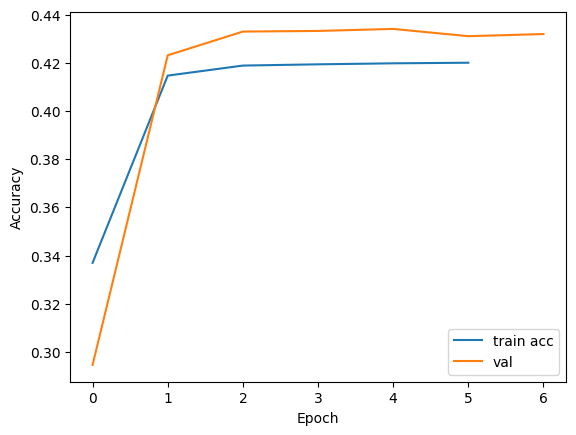

In [ ]:
# Accuracy
plt.plot(history.history['accuracy'][1:], label='train acc')
plt.plot(history.history['val_accuracy'], label='val')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

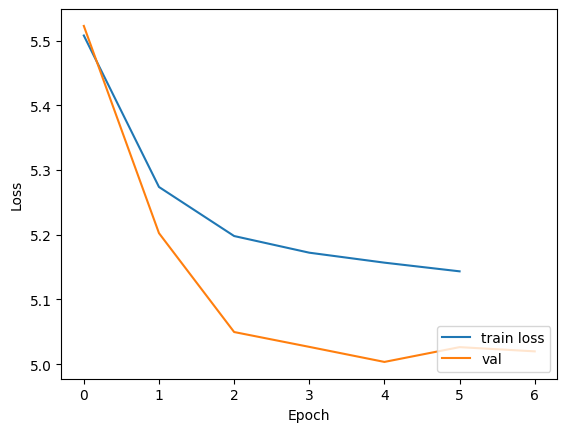

In [ ]:
# Loss
plt.plot(history.history['loss'][1:], label='train loss')
plt.plot(history.history['val_loss'], label='val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')

In [ ]:
# Inference
encoder_model, decoder_model = inference_func(
    max_text_len, latent_dim, encoder_input, encoder_output,
    encoder_final_states, decoder_input, decoder_output,
    decoder_embedding_layer, decoder_dense, last_decoder_lstm
)

In [ ]:
encoder_model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 42)]              0         
                                                                 
 embedding_2 (Embedding)     (None, 42, 300)           29943000  
                                                                 
 lstm_3 (LSTM)               [(None, 42, 240),         519360    
                              (None, 240),                       
                              (None, 240)]                       
                                                                 
 lstm_4 (LSTM)               [(None, 42, 240),         461760    
                              (None, 240),                       
                              (None, 240)]                       
                                                                 
Total params: 30,924,120
Trainable params: 981,120
Non-trai

In [ ]:
decoder_model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding_3 (Embedding)        (None, None, 300)    11240700    ['input_7[0][0]']                
                                                                                                  
 input_8 (InputLayer)           [(None, 240)]        0           []                               
                                                                                                  
 input_9 (InputLayer)           [(None, 240)]        0           []                               
                                                                                            

In [ ]:
# Testing on training data
for i in range(0, 10):
    print(f"# {i+1} News: ", seq2text(x_train_padded[i]))
    print("Original summary: ", seq2summary(y_train_padded[i]))
    print(
        "Predicted summary: ",
        decode_sequence_func(
            x_train_padded[i].reshape(1, max_text_len), encoder_model,
            decoder_model
        )
    )
    print()

# 1 News:  responding criticism changing name sonam kapoor ahuja following wedding anand ahuja sonam kapoor questioned know anand changed name people understand concept ftheminism need go online look description added sonam said changing surname iage choice 
Original summary:  start know anand changed surname post iage sonam end 
1/1 [==============================] - 0s 59ms/step
Predicted summary:   start man man india india india end

# 2 News:  suprtheme court upheld death penalty four convicts nirbhaya gangrape case convicts lawyer said file review petition reading order alleging human rights convicts neglected added justice done cannot give death sentence anyone message nation 
Original summary:  start nirbhaya gangrape convicts file review petition sc end 
1/1 [==============================] - 0s 68ms/step
Predicted summary:   start man man india india india end

# 3 News:  several women taking instagram post pictures feather eyebrows involves rating eyebrow hair parting runnin

**Model with Bidirectional LSTMs**

In [ ]:
model_func = models_info['bidirectional_lstm']['model']
inference_func = models_info['bidirectional_lstm']['inference']
decode_sequence_func = models_info['bidirectional_lstm']['decode_sequence']

In [ ]:
seq2seq = model_func(
    embedding_dim, latent_dim, max_text_len,
    x_vocab_size, y_vocab_size,
    x_embedding_matrix, y_embedding_matrix
)

model = seq2seq['model']

encoder_input = seq2seq['inputs']['encoder']
decoder_input = seq2seq['inputs']['decoder']

encoder_output = seq2seq['outputs']['encoder']
decoder_output = seq2seq['outputs']['decoder']

encoder_final_states = seq2seq['states']['encoder']
decoder_final_states = seq2seq['states']['decoder']

decoder_embedding_layer = seq2seq['layers']['decoder']['embedding']
last_decoder_lstm = seq2seq['layers']['decoder']['last_decoder_lstm']
decoder_dense = seq2seq['layers']['decoder']['dense']

model.summary()

Model: "seq2seq_model_with_bidirectional_lstm"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 42)]         0           []                               
                                                                                                  
 encoder_embedding (Embedding)  (None, 42, 300)      29943000    ['input_11[0][0]']               
                                                                                                  
 encoder_bidirectional_lstm_1 (  [(None, 42, 480),   1038720     ['encoder_embedding[0][0]']      
 Bidirectional)                  (None, 240),                                                     
                                 (None, 240),                                                     
                                 (None, 240),                 

In [ ]:
history = model.fit(
    [x_train_padded, y_train_padded[:, :-1]],
    y_train_padded.reshape(y_train_padded.shape[0], y_train_padded.shape[1], 1)[:, 1:],
    epochs=num_epochs,
    batch_size=128 * tpu_strategy.num_replicas_in_sync,
    callbacks=callbacks,
    validation_data=(
        [x_val_padded, y_val_padded[:, :-1]],
        y_val_padded.reshape(y_val_padded.shape[0], y_val_padded.shape[1], 1)[:, 1:]
    )
)

Epoch 1/50
89/89 [==============================] - 116s 735ms/step - loss: 6.1158 - accuracy: 0.3560 - val_loss: 5.0553 - val_accuracy: 0.4323 - lr: 0.0010
Epoch 2/50
89/89 [==============================] - 21s 240ms/step - loss: 5.1111 - accuracy: 0.4208 - val_loss: 4.8771 - val_accuracy: 0.4372 - lr: 0.0010
Epoch 3/50
89/89 [==============================] - 21s 241ms/step - loss: 4.9889 - accuracy: 0.4249 - val_loss: 4.7735 - val_accuracy: 0.4437 - lr: 0.0010
Epoch 4/50
89/89 [==============================] - 21s 240ms/step - loss: 4.8770 - accuracy: 0.4309 - val_loss: 4.6415 - val_accuracy: 0.4461 - lr: 0.0010
Epoch 5/50
89/89 [==============================] - 22s 243ms/step - loss: 4.7427 - accuracy: 0.4383 - val_loss: 4.4961 - val_accuracy: 0.4558 - lr: 0.0010
Epoch 6/50
89/89 [==============================] - 21s 240ms/step - loss: 4.6087 - accuracy: 0.4463 - val_loss: 4.3598 - val_accuracy: 0.4625 - lr: 0.0010
Epoch 7/50
89/89 [==============================] - 21s 240ms/s

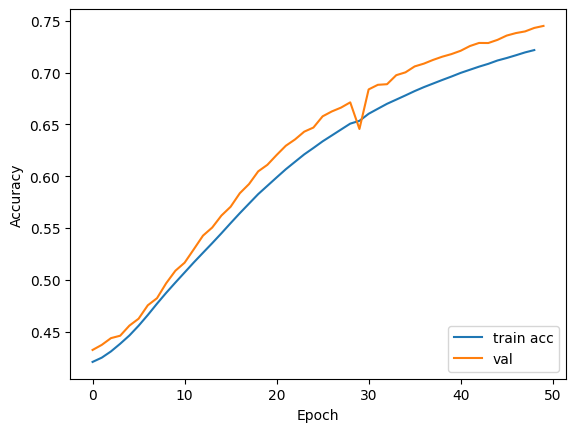

In [ ]:
# Accuracy
plt.plot(history.history['accuracy'][1:], label='train acc')
plt.plot(history.history['val_accuracy'], label='val')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

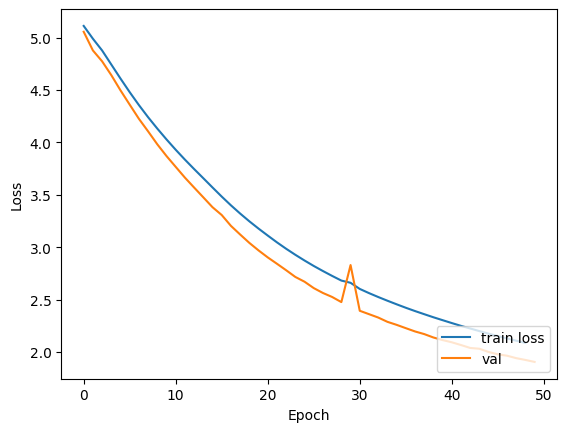

In [ ]:
# Loss
plt.plot(history.history['loss'][1:], label='train loss')
plt.plot(history.history['val_loss'], label='val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')

In [ ]:
# Inference
encoder_model, decoder_model = inference_func(
    max_text_len, latent_dim, encoder_input, encoder_output,
    encoder_final_states, decoder_input, decoder_output,
    decoder_embedding_layer, decoder_dense, last_decoder_lstm
)

In [ ]:
encoder_model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 42)]              0         
                                                                 
 encoder_embedding (Embeddin  (None, 42, 300)          29943000  
 g)                                                              
                                                                 
 encoder_bidirectional_lstm_  [(None, 42, 480),        1038720   
 1 (Bidirectional)            (None, 240),                       
                              (None, 240),                       
                              (None, 240),                       
                              (None, 240)]                       
                                                                 
 encoder_bidirectional_lstm_  [(None, 42, 480),        1384320   
 2 (Bidirectional)            (None, 240),                 

In [ ]:
decoder_model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None, None)]       0           []                               
                                                                                                  
 decoder_embedding (Embedding)  (None, None, 300)    11240700    ['input_12[0][0]']               
                                                                                                  
 input_13 (InputLayer)          [(None, 240)]        0           []                               
                                                                                                  
 input_14 (InputLayer)          [(None, 240)]        0           []                               
                                                                                            

In [ ]:
# Testing on training data
for i in range(0, 10):
    print(f"# {i+1} News: ", seq2text(x_train_padded[i]))
    print("Original summary: ", seq2summary(y_train_padded[i]))
    print(
        "Predicted summary: ",
        decode_sequence_func(
            x_train_padded[i].reshape(1, max_text_len), encoder_model,
            decoder_model
        )
    )
    print()

# 1 News:  responding criticism changing name sonam kapoor ahuja following wedding anand ahuja sonam kapoor questioned know anand changed name people understand concept ftheminism need go online look description added sonam said changing surname iage choice 
Original summary:  start know anand changed surname post iage sonam end 
1/1 [==============================] - 0s 73ms/step
Predicted summary:   sostok india start india start plan start india start india start india

# 2 News:  suprtheme court upheld death penalty four convicts nirbhaya gangrape case convicts lawyer said file review petition reading order alleging human rights convicts neglected added justice done cannot give death sentence anyone message nation 
Original summary:  start nirbhaya gangrape convicts file review petition sc end 
1/1 [==============================] - 0s 73ms/step
Predicted summary:   sostok india start gets start gets start gets start gets start gets

# 3 News:  several women taking instagram post p

### Model with hybrid architecture

In [ ]:
model_func = models_info['hybrid_model']['model']
inference_func = models_info['hybrid_model']['inference']
decode_sequence_func = models_info['hybrid_model']['decode_sequence']

In [ ]:
seq2seq = model_func(
    embedding_dim, latent_dim, max_text_len,
    x_vocab_size, y_vocab_size,
    x_embedding_matrix, y_embedding_matrix
)

model = seq2seq['model']

encoder_input = seq2seq['inputs']['encoder']
decoder_input = seq2seq['inputs']['decoder']

encoder_output = seq2seq['outputs']['encoder']
decoder_output = seq2seq['outputs']['decoder']

encoder_final_states = seq2seq['states']['encoder']
decoder_final_states = seq2seq['states']['decoder']

decoder_embedding_layer = seq2seq['layers']['decoder']['embedding']
last_decoder_lstm = seq2seq['layers']['decoder']['last_decoder_lstm']
decoder_dense = seq2seq['layers']['decoder']['dense']

model.summary()

Model: "seq2seq_model_with_bidirectional_lstm"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_18 (InputLayer)          [(None, 42)]         0           []                               
                                                                                                  
 encoder_embedding (Embedding)  (None, 42, 300)      29943000    ['input_18[0][0]']               
                                                                                                  
 encoder_bidirectional_lstm_1 (  [(None, 42, 480),   1038720     ['encoder_embedding[0][0]']      
 Bidirectional)                  (None, 240),                                                     
                                 (None, 240),                                                     
                                 (None, 240),                 

In [ ]:
history = model.fit(
    [x_train_padded, y_train_padded[:, :-1]],
    y_train_padded.reshape(y_train_padded.shape[0], y_train_padded.shape[1], 1)[:, 1:],
    epochs=num_epochs,
    batch_size=128 * tpu_strategy.num_replicas_in_sync,
    callbacks=callbacks,
    validation_data=(
        [x_val_padded, y_val_padded[:, :-1]],
        y_val_padded.reshape(y_val_padded.shape[0], y_val_padded.shape[1], 1)[:, 1:]
    )
)

Epoch 1/50


89/89 [==============================] - 95s 584ms/step - loss: 6.6489 - accuracy: 0.2558 - val_loss: 5.5549 - val_accuracy: 0.3129 - lr: 0.0010
Epoch 2/50
89/89 [==============================] - 18s 199ms/step - loss: 5.5287 - accuracy: 0.3292 - val_loss: 5.2059 - val_accuracy: 0.3968 - lr: 0.0010
Epoch 3/50
89/89 [==============================] - 18s 198ms/step - loss: 5.2838 - accuracy: 0.4126 - val_loss: 5.0659 - val_accuracy: 0.4325 - lr: 0.0010
Epoch 4/50
89/89 [==============================] - 18s 198ms/step - loss: 5.1997 - accuracy: 0.4189 - val_loss: 5.0247 - val_accuracy: 0.4337 - lr: 0.0010
Epoch 5/50
89/89 [==============================] - 18s 199ms/step - loss: 5.1714 - accuracy: 0.4193 - val_loss: 4.9983 - val_accuracy: 0.4331 - lr: 0.0010
Epoch 6/50
89/89 [==============================] - 18s 201ms/step - loss: 5.1553 - accuracy: 0.4197 - val_loss: 4.9913 - val_accuracy: 0.4342 - lr: 0.0010
Epoch 7/50
89/89 [==============================] - 18s 199ms/step - loss: 

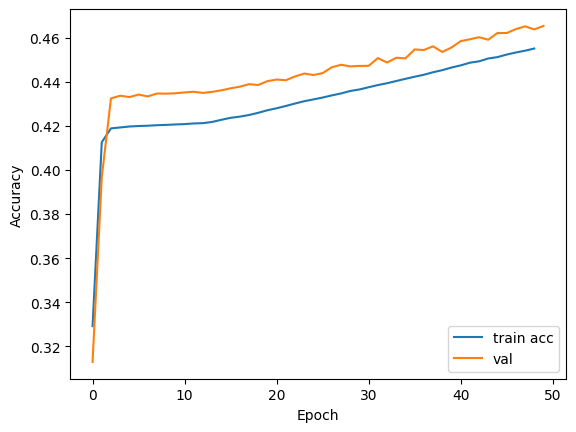

In [ ]:
# Accuracy
plt.plot(history.history['accuracy'][1:], label='train acc')
plt.plot(history.history['val_accuracy'], label='val')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

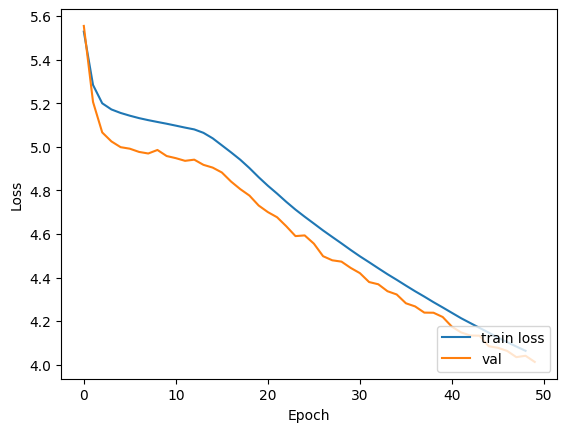

In [ ]:
# Loss
plt.plot(history.history['loss'][1:], label='train loss')
plt.plot(history.history['val_loss'], label='val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')

In [ ]:
# Inference
encoder_model, decoder_model = inference_func(
    max_text_len, latent_dim, encoder_input, encoder_output,
    encoder_final_states, decoder_input, decoder_output,
    decoder_embedding_layer, decoder_dense, last_decoder_lstm
)

In [ ]:
encoder_model.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_18 (InputLayer)       [(None, 42)]              0         
                                                                 
 encoder_embedding (Embeddin  (None, 42, 300)          29943000  
 g)                                                              
                                                                 
 encoder_bidirectional_lstm_  [(None, 42, 480),        1038720   
 1 (Bidirectional)            (None, 240),                       
                              (None, 240),                       
                              (None, 240),                       
                              (None, 240)]                       
                                                                 
 encoder_bidirectional_lstm_  [(None, 42, 480),        1384320   
 2 (Bidirectional)            (None, 240),                 

In [ ]:
decoder_model.summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_19 (InputLayer)          [(None, None)]       0           []                               
                                                                                                  
 decoder_embedding (Embedding)  (None, None, 300)    11240700    ['input_19[0][0]']               
                                                                                                  
 input_20 (InputLayer)          [(None, 240)]        0           []                               
                                                                                                  
 input_21 (InputLayer)          [(None, 240)]        0           []                               
                                                                                            

In [ ]:
# Testing on training data
for i in range(0, 10):
    print(f"# {i+1} News: ", seq2text(x_train_padded[i]))
    print("Original summary: ", seq2summary(y_train_padded[i]))
    print(
        "Predicted summary: ",
        decode_sequence_func(
            x_train_padded[i].reshape(1, max_text_len), encoder_model,
            decoder_model
        )
    )
    print()

# 1 News:  responding criticism changing name sonam kapoor ahuja following wedding anand ahuja sonam kapoor questioned know anand changed name people understand concept ftheminism need go online look description added sonam said changing surname iage choice 
Original summary:  start know anand changed surname post iage sonam end 
1/1 [==============================] - 0s 63ms/step
Predicted summary:   sostok makes life flights flights rape start india end end end end

# 2 News:  suprtheme court upheld death penalty four convicts nirbhaya gangrape case convicts lawyer said file review petition reading order alleging human rights convicts neglected added justice done cannot give death sentence anyone message nation 
Original summary:  start nirbhaya gangrape convicts file review petition sc end 
1/1 [==============================] - 0s 69ms/step
Predicted summary:   sostok gets wife wife wife ball people start india end end end

# 3 News:  several women taking instagram post pictures fe

---

I'll wrap things up there. If you want to find some other answers then go ahead `edit` this kernel. If you have any `questions` then do let me know.

If this kernel helped you then don't forget to 🔼 `upvote` and share your 🎙 `feedback` on improvements of the kernel.

![](https://media.giphy.com/media/3o85xAYQLOhSrmINHO/giphy.gif)

---